In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
#enumerate all possible board locations
board_locations = set([(i,j) for i in range(8) for j in range(8)])

In [3]:
indices = random.sample(sorted(board_locations), 8)
board = np.zeros((8, 8), dtype=int)
#fill board with queens using indices
for i, j in indices:
    board[i][j] = 1

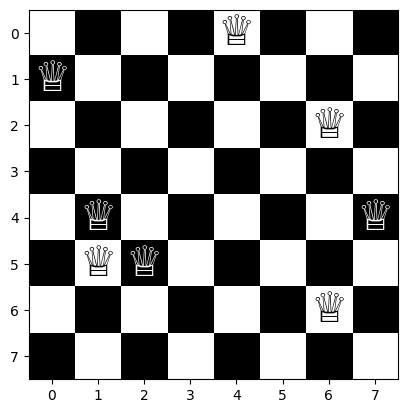

In [4]:
#plot board
chessboard = np.zeros((8,8))
chessboard[1::2,0::2] = 1
chessboard[0::2,1::2] = 1
plt.imshow(chessboard, cmap='binary')
for i, j in indices:
    plt.text(j, i, '♕', fontsize=30, ha='center', va='center', color='black' if (i - j) % 2 == 0 else 'white')

In [5]:
# function to plot the board with queens
def plot_board(individual):

    chessboard = np.zeros((8, 8))
    chessboard[1::2, 0::2] = 1
    chessboard[0::2, 1::2] = 1
    plt.imshow(chessboard, cmap='binary')
    for i, j in individual:
        plt.text(j, i, '♕', fontsize=30, ha='center', va='center',
                 color='black' if (i - j) % 2 == 0 else 'white')
    plt.show()

In [6]:
def evaluate(individual):

    size = len(individual)
    # check for queens in the same row
    board = np.zeros((8, 8), dtype=int)


    # fill board with queens using indices
    for i, j in individual:
        board[i][j] = 1

    individual = board
    
    row_clashes = sum(np.clip(np.sum(individual, axis=1), 1, None) - 1)
    # check for queens in the same column
    column_clashes = sum(np.clip(np.sum(individual, axis=0), 1, None) - 1)

    row_indices, column_indices = np.where(individual == 1)

    left_diagonals = [0] * (2 * size - 1)
    right_diagonals = [0] * (2 * size - 1)

    for qr, qc in zip(row_indices, column_indices):
        left_diagonals[qr + qc] += 1
        right_diagonals[size - 1 - qr + qc] += 1

    left_diagonals, right_diagonals = np.array(
        left_diagonals), np.array(right_diagonals)
    # clip diagonals
    left_diagonals = np.clip(left_diagonals, 1, None) - 1
    right_diagonals = np.clip(right_diagonals, 1, None) - 1
    diagonal_clashes = (np.sum(left_diagonals)) + (np.sum(right_diagonals))
    # print(row_clashes, column_clashes, diagonal_clashes)

    clashes = row_clashes + column_clashes + diagonal_clashes

    return clashes,

In [7]:
def crossover(ind_1, ind_2):

    indices_to_cross = random.sample(range(8), 4)
    for i in indices_to_cross:
        #cross index if it isn't present in the individual, else continue
        if ind_1[i] not in ind_2 and ind_2[i] not in ind_1:
            ind_1[i], ind_2[i] = ind_2[i], ind_1[i]
        else:
            continue
    
    return ind_1, ind_2
            

In [8]:
def mutate(individual):

    #randomly select one indice
    indice_to_mutate = random.choice(range(8))
    x, y  = individual[indice_to_mutate]
    if (y, x) not in individual:
        individual[indice_to_mutate] = (y, x)
    
    return individual,

In [9]:
def eaSimple(population, toolbox, cxpb, mutpb, ngen, max, stats=None, halloffame=None, ):  
    # Create a logbook to store statistics about the evolution process
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the fitness of the initial population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the initial population if provided
    if halloffame is not None:
        halloffame.update(population)

    # Record the statistics of the initial population
    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: 
            plot_board(halloffame[0])
            return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Clone the selected individuals to create the offspring
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                # Invalidate the fitness values of the offspring
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                # Invalidate the fitness value of the offspring
                del offspring[i].fitness.values

        # Evaluate the fitness of the offspring
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit 
            # Check if the solution has been found
            if fit[0] == 0:
              print("Solved")
              
              done = True

        # Update the hall of fame with the best individuals found so far
        if halloffame is not None:
            halloffame.update(offspring)       
            # plot_board(halloffame[0])            

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)
    plot_board(halloffame[0])

### Testing DEAP

In [10]:
from deap import base, creator, tools, algorithms


In [11]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [12]:
toolbox = base.Toolbox()
toolbox.register("positions", random.sample, sorted(board_locations), 8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.positions)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register('select', tools.selTournament, tournsize=3)

In [13]:
#get 2 individuals
ind1, ind2 = toolbox.individual(), toolbox.individual()
#print them
print(ind1)
print(ind2)



[(1, 5), (1, 6), (3, 4), (1, 0), (6, 1), (6, 0), (4, 0), (7, 2)]
[(4, 7), (5, 2), (1, 3), (7, 3), (1, 5), (2, 7), (3, 6), (5, 0)]


In [83]:
ind1, ind2 = toolbox.mate(ind1, ind2)

In [84]:
print(ind1)
print(ind2)

[(7, 4), (0, 5), (4, 7), (0, 4), (2, 0), (1, 4), (5, 0), (2, 1)]
[(5, 1), (1, 4), (5, 0), (6, 7), (5, 4), (3, 2), (0, 5), (3, 6)]


In [85]:
ind1 = toolbox.mutate(ind1)
ind2 = toolbox.mutate(ind2)

In [86]:
ind2 = toolbox.mutate(ind2)
print(ind2)

[(5, 1), (4, 1), (5, 0), (6, 7), (5, 4), (2, 3), (0, 5), (3, 6)]


In [87]:
#evaluate the individuals
print(toolbox.evaluate(ind1))
print(toolbox.evaluate(ind2))

2 3 4
9
2 1 5
8


### Running DEAP

In [14]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("positions", random.sample, sorted(board_locations), 8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.positions)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register('select', tools.selTournament, tournsize=3)

/Users/akhtar/opt/anaconda3/envs/new_tf/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/akhtar/opt/anaconda3/envs/new_tf/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	Avg  	Std    	Min	Max
0  	1000  	8.573	1.54035	4  	13 
1  	1000  	8.162	1.48854	3  	13 
2  	1000  	7.935	1.52012	4  	13 
3  	1000  	7.758	1.50912	3  	12 
4  	1000  	7.707	1.50637	3  	13 
5  	1000  	7.78 	1.50519	3  	12 
6  	1000  	7.742	1.46541	4  	13 
7  	1000  	7.73 	1.47821	3  	12 
8  	1000  	7.617	1.44094	3  	13 
9  	1000  	7.533	1.46387	3  	12 
10 	1000  	7.668	1.45938	3  	12 
11 	1000  	7.574	1.53575	3  	12 
12 	1000  	7.562	1.46566	3  	12 
13 	1000  	7.475	1.53668	2  	13 
14 	1000  	7.524	1.45307	3  	12 
15 	1000  	7.496	1.49063	2  	13 
16 	1000  	7.443	1.50225	3  	13 
17 	1000  	7.383	1.48738	3  	12 
18 	1000  	7.317	1.48543	3  	12 
19 	1000  	7.175	1.49946	2  	12 
20 	1000  	7.112	1.44688	2  	11 
21 	1000  	7    	1.43597	3  	11 
22 	1000  	6.791	1.42735	3  	11 
23 	1000  	6.702	1.40826	3  	11 
24 	1000  	6.562	1.45195	2  	12 
25 	1000  	6.417	1.38026	3  	11 
26 	1000  	6.371	1.33767	2  	10 
27 	1000  	6.206	1.34743	2  	11 
28 	1000  	6.137	1.3661 	1  	11 
29 	1000  

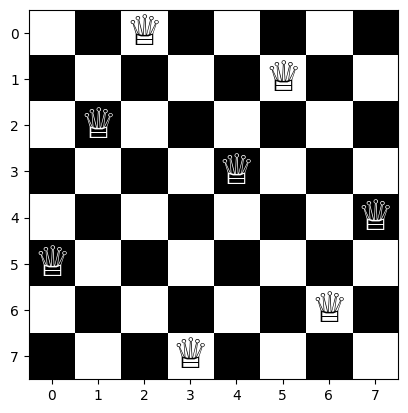

In [15]:
seed = 99
random.seed(seed)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", np.mean)
stats.register("Std", np.std)
stats.register("Min", np.min)
stats.register("Max", np.max)

eaSimple(pop, toolbox, cxpb=1, mutpb=1, ngen=100, max = 8,
         stats=stats ,halloffame=hof)